In [209]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm

np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV



In [210]:
def summary_model(X, y, label='scatter'):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    summary = model.summary()
    return summary

def plot_model(X, y, label='Residual Plot'):
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)

    plt.scatter(y_hats, student_resids, alpha = .35, label=label)
    plt.legend()
    plt.show()

In [240]:
covid = pd.read_csv('full_feature_covid.csv')
covid = covid.set_index('GEOID')

#clean up nans
covid = covid.fillna(0)

#break out categorical data
covid = pd.get_dummies(covid, columns=['DominantReligion','Region'])

#save georegion for later
geocols = ['Geographical_Point','Target_PctChg']
geo = covid[geocols]

#Drop categorical columns that won't help with our model
cols = ['County', 'State','Geographical_Point']
covid = covid.drop(cols, axis = 1)

#normalize data
covid['Target_PctChg'] = covid['Target_PctChg']/10
covid['Unempl_Rate'] = covid['Unempl_Rate']/100
covid['Median_HHI'] = covid['Median_HHI']/covid['Median_HHI'].sum()
covid['DensPerSqMile'] = covid['DensPerSqMile']/covid['DensPerSqMile'].sum()
covid['Avg_HH_Size'] = covid['Avg_HH_Size']/10
covid['Avg_Fam_Size'] = covid['Avg_Fam_Size']/10
covid.mean(axis=0)

covid.head()



,Target_PctChg,AgeUnder15,Age15to24,Age25to34,Age35to44,Age45to64,Age65to84,asAgeOver85,Married_Family,Avg_HH_Size,...,per_dem,per_gop,DominantReligion_Catholic,DominantReligion_Evangelical,DominantReligion_Mainline,DominantReligion_Other,Region_Midwest,Region_Northeast,Region_South,Region_West
GEOID,,,,,,,,,,,,,,,,,,,,,
10001,0.006987,0.129,0.136,0.138,0.115,0.244,0.158,0.020,0.458,0.259,...,0.511945,0.471232,1,0,0,0,0,0,1,0
10003,-0.017158,0.119,0.129,0.145,0.125,0.265,0.144,0.016,0.448,0.256,...,0.678065,0.307211,1,0,0,0,0,0,1,0
10005,-0.038147,0.104,0.092,0.096,0.099,0.271,0.264,0.026,0.538,0.239,...,0.438200,0.550668,1,0,0,0,0,0,1,0
1003,0.194856,0.121,0.116,0.109,0.128,0.265,0.195,0.019,0.513,0.268,...,0.224090,0.761714,0,1,0,0,0,0,1,0
1015,0.129139,0.117,0.127,0.132,0.127,0.257,0.164,0.016,0.461,0.248,...,0.298452,0.688484,0,1,0,0,0,0,1,0


In [222]:
covid.describe()

,Target_PctChg,AgeUnder15,Age15to24,Age25to34,Age35to44,Age45to64,Age65to84,asAgeOver85,Married_Family,Avg_HH_Size,...,per_dem,per_gop,DominantReligion_Catholic,DominantReligion_Evangelical,DominantReligion_Mainline,DominantReligion_Other,Region_Midwest,Region_Northeast,Region_South,Region_West
count,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,...,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000
mean,0.427263,0.125133,0.135285,0.130447,0.123367,0.255833,0.152697,0.019597,0.488356,0.257858,...,0.449341,0.531480,0.605230,0.313823,0.026152,0.054795,0.239103,0.163138,0.437111,0.160648
std,1.246977,0.018309,0.034695,0.020939,0.013735,0.025894,0.038703,0.006766,0.071041,0.025087,...,0.148194,0.149144,0.489106,0.464335,0.159686,0.227721,0.426802,0.369722,0.496338,0.367434
min,-1.000000,0.035000,0.052000,0.045000,0.066000,0.142000,0.070000,0.005000,0.234000,0.198000,...,0.106999,0.053973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.374599,0.114000,0.117000,0.117500,0.115000,0.240500,0.130000,0.015000,0.445500,0.240500,...,0.333587,0.427540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.032717,0.125000,0.127000,0.128000,0.123000,0.259000,0.148000,0.019000,0.487000,0.253000,...,0.432861,0.549399,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.876443,0.135000,0.140000,0.141000,0.131000,0.272500,0.169000,0.023000,0.534000,0.270000,...,0.549229,0.649474,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,12.678571,0.189000,0.359000,0.239000,0.170000,0.323000,0.559000,0.057000,0.726000,0.358000,...,0.921497,0.881221,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [224]:
X = covid.copy()
y = X.pop('Target_PctChg')

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y, test_size=0.2, random_state=1) 

In [65]:
X = covid.copy()
y = X.pop('Target_PctChg')

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y, test_size=0.2, random_state=1) 

summary = summary_model(X_train,y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Target_PctChg   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     4.248
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           2.47e-13
Time:                        14:38:16   Log-Likelihood:                 495.80
No. Observations:                 642   AIC:                            -923.6
Df Residuals:                     608   BIC:                            -771.8
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -9.7455      4.705     -2.071      0.039     -18.985      -0.506
AgeUnder15                                        1.6306      1.342      1.215      0.225      -1.004       4.266
Age15to24                                         1.0178      0.997      1.021      0.308      -0.940       2.976
Age25to34                                         1.8140      1.170      1.550      0.122      -0.484       4.112
Age35to44                                         1.1710      1.181      0.992      0.322      -1.148       3.490
Age45to64                                         0.9289      0.986      0.942      0.346      -1.007       2.865
Age65to84                                         1.4615      1.018      1.436      0.152      -0.537       3.460
asAgeOver85                                       3.3681      1.390      2.423      0.016       0.638       6.098
Married_Family                                   -0.1050      0.193     -0.543      0.587      -0.485       0.275
Avg_HH_Size                                       1.4259      0.860      1.658      0.098      -0.263       3.115
Avg_Fam_Size                                     -1.2164      0.625     -1.947      0.052      -2.443       0.010
High_School                                      -0.1636      0.211     -0.776      0.438      -0.578       0.250
BS                                                0.1893      0.119      1.593      0.112      -0.044       0.423
Veterans                                          0.0617      0.248      0.248      0.804      -0.426       0.550
Born_in_State                                    -0.0198      0.050     -0.393      0.694      -0.119       0.079
Own_Comp                                         -0.0812      0.297     -0.273      0.785      -0.665       0.503
Broadband_Access                                  0.0248      0.165      0.150      0.881      -0.300       0.349
Median_HHI                                       55.3154     39.969      1.384      0.167     -23.180     133.810
Unempl_Rate                                      -0.6027      0.369     -1.635      0.103      -1.327       0.121
maskLow                                          13.5327      6.979      1.939      0.053      -0.174      27.240
maskHigh                                         13.7108      6.981      1.964      0.050       0.001      27.420
DensPerSqMile                                    -2.7229      2.382     -1.143      0.253      -7.401       1.955
Religiosity                                       0.0542      0.045      1.208      0.228      -0.034       0.142
vaccineHest                                       0.2190      0.069      3.163      0.002       0.083       0.355
CVAC_

In [225]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
#linear regression
ols = linear_model.LinearRegression()
model = ols.fit(X_train, y_train)
y_hat_ols = model.predict(X_test)
mse = mean_squared_error(y_hat_ols, y_test)
mse

mean_arr = np.zeros(y_test.shape)
mean_arr[mean_arr==0] = y.mean()
y_hat_mean = mean_arr
#residuals = mean_arr - y
#print(mean_squared_error(y, mean_arr))
#mean_arr

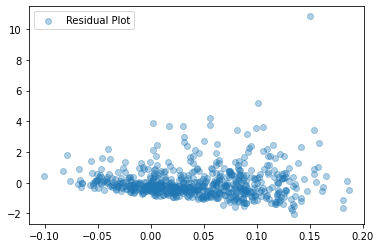

In [85]:
#importances = pd.DataFrame(data={'Attribute': X_train.columns, 'Importance': model.coef_[0]})

plot_model(X_train,y_train)

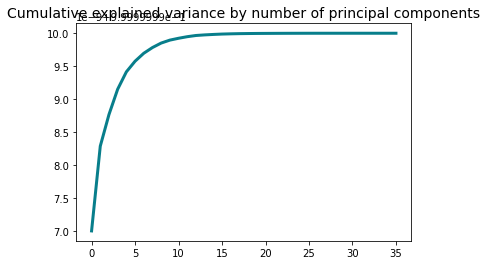

In [176]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=14)

plt.show()

In [1]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)
loadings.head(20)

NameError: name 'pd' is not defined

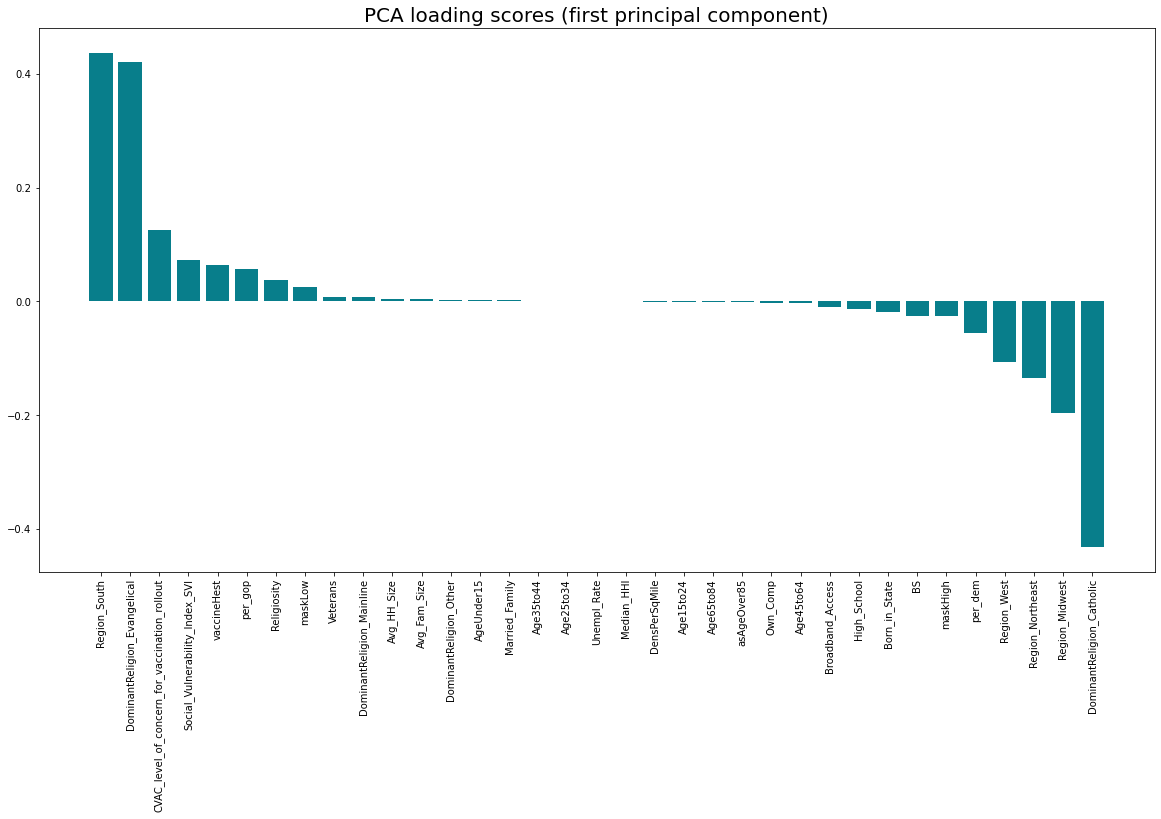

In [177]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.figure(figsize=(20,10))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')

plt.savefig('PCA.png', dpi=100)
plt.show()

In [188]:
cols = ['Target_PctChg','Region_South','DominantReligion_Evangelical','CVAC_level_of_concern_for_vaccination_rollout','Social_Vulnerability_Index_SVI','vaccineHest']

pca = covid[cols]

X = pca.copy()
y = X.pop('Target_PctChg')

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y, test_size=0.2, random_state=1) 

In [190]:
def learning_curves(X_train, y_train, X_test, y_test):
    
    fig = plt.figure(figsize=(10,8))
    # Generate 40 evenly spaced numbers (rounded to nearest integer) over a specified interval 1 to 354
    datapoints = np.rint(np.linspace(1, len(X_train), 40)).astype(int)
    #initialise array of shape (40,)
    train_err = np.zeros(len(datapoints))
    test_err = np.zeros(len(datapoints))
 
    # Create 6 different models based on max_depth
    for k, depth in enumerate(range(1,7)):
        for i, s in enumerate(datapoints):
            reg = DecisionTreeRegressor(max_depth = depth) #increasing depth
            # Iteratively increase training set size
            reg.fit(X_train[:s], y_train[:s])
            # MSE for training and test sets of increasing size
            train_err[i] = mean_squared_error(y_train[:s], reg.predict(X_train[:s]))
            test_err[i] = mean_squared_error(y_test, reg.predict(X_test))

        print('Train_error: {}'.format(train_err[-1]))
        print('Test_error: {}'.format(test_err[-1]))
 
        # Subplot learning curves
        sub = fig.add_subplot(3, 3, k+1)
        sub.plot(datapoints, test_err, lw = 1, label = 'Testing Error')
        sub.plot(datapoints, train_err, lw = 1, label = 'Training Error')
        sub.legend()
        sub.set_title('DT Max Depth = %s'%(depth))
        sub.set_xlabel('No. of Data Points in Training Set')
        sub.set_ylabel('Total Error')
        sub.set_xlim([0, len(X_train)])
        
        fig.suptitle('Decision Tree Regressor Learning Curves', fontsize=18, y=1.03)
        fig.tight_layout()
        fig.show()

Train_error: 0.014203196916702314
Test_error: 0.014129369932542477
<ipython-input-190-27db3bfd0334>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Train_error: 0.01348773313700269
Test_error: 0.014477334859977061
<ipython-input-190-27db3bfd0334>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Train_error: 0.010862067460129018
Test_error: 0.013416434184858838
<ipython-input-190-27db3bfd0334>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Train_error: 0.009861024042769988
Test_error: 0.015836059691621194
<ipython-input-190-27db3bfd0334>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show th

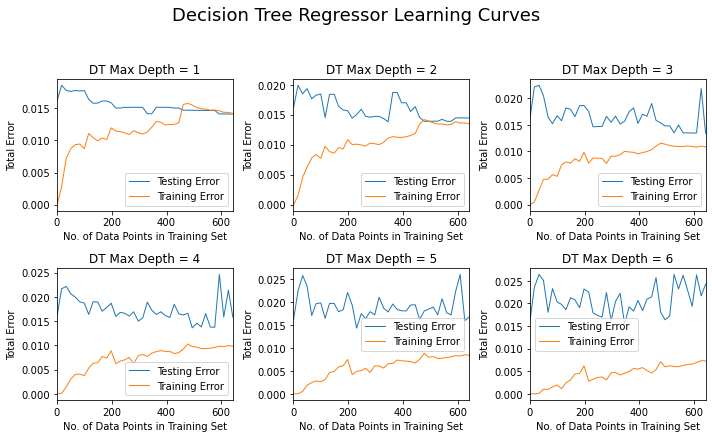

In [231]:
learning_curves(X_train, y_train, X_test, y_test);

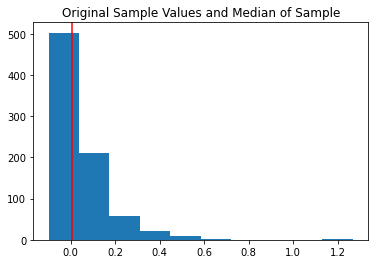

In [98]:
fig, ax = plt.subplots()

ax.hist(y)
ax.axvline(np.median(y), color = 'red')
ax.set_title('Original Sample Values and Median of Sample');

In [99]:
def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.))), medians

The 95.0% confidence interval of the median is from -0.002 to 0.011


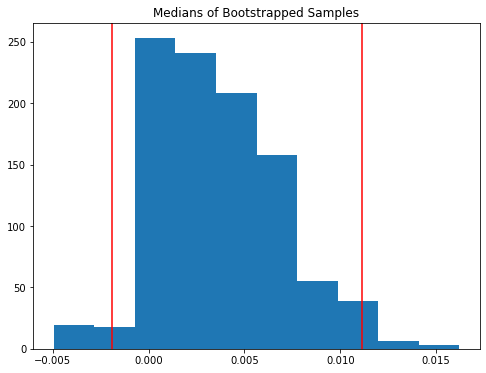

In [100]:
alpha = .05
ci = bootstrap_confidence_interval(y, np.median, alpha)

print(f"The {100-100*alpha}% confidence interval of the median is from {ci[0][0]:.3f} to {ci[0][1]:.3f}")

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(ci[1])
ax.axvline(ci[0][0], color = 'red')
ax.axvline(ci[0][1], color = 'red')
ax.set_title('Medians of Bootstrapped Samples');

In [226]:
#decision tree
dt = DecisionTreeRegressor(max_depth=6)
dt.fit(X_train, y_train)
y_hat_dt = dt.predict(X_test)
mse = mean_squared_error(y_hat, y_test)

mse


1.635379126215141

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [228]:
#random Forest
model = RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt')

model.fit(X_train, y_train)

# Actual class predictions
rf_predictions = model.predict(X_test)

rf_predictions
# Probabilities for each class
#rf_probs = model.predict_proba(X_test)[:, 1]



# Calculate roc auc
#roc_value = roc_auc_score(y_test, rf_probs)
mse_rf = mean_squared_error(rf_predictions, y_test)

mse_rf

0.013356973093461816

In [229]:
best_model = RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=20, bootstrap=False)

best_model.fit(X_train, y_train)

# Actual class predictions
rf_predictions = best_model.predict(X_test)

mse_rf = mean_squared_error(rf_predictions, y_test)

mse_rf

#Predict the entire data set
all_predictions = best_model.predict(X)

0.012881445632716836

In [246]:
#Predict the entire data set
all_predictions = best_model.predict(X)

predicted_rate_of_change = np.array(all_predictions*10)

geo.info()

geo['NewPrediction'] = predicted_rate_of_change

geo.describe()

geo.index

#what counties are increasing?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 10001 to 9015
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Geographical_Point  803 non-null    object 
 1   Target_PctChg       803 non-null    float64
 2   NewPrediction       803 non-null    float64
dtypes: float64(2), object(1)
memory usage: 57.4+ KB


Int64Index([10001, 10003, 10005,  1003,  1015,  1043,  1049,  1051,  1055,
             1069,
            ...
             8077,  8101,  9001,  9003,  9005,  9007,  9009,  9011,  9013,
             9015],
           dtype='int64', name='GEOID', length=803)

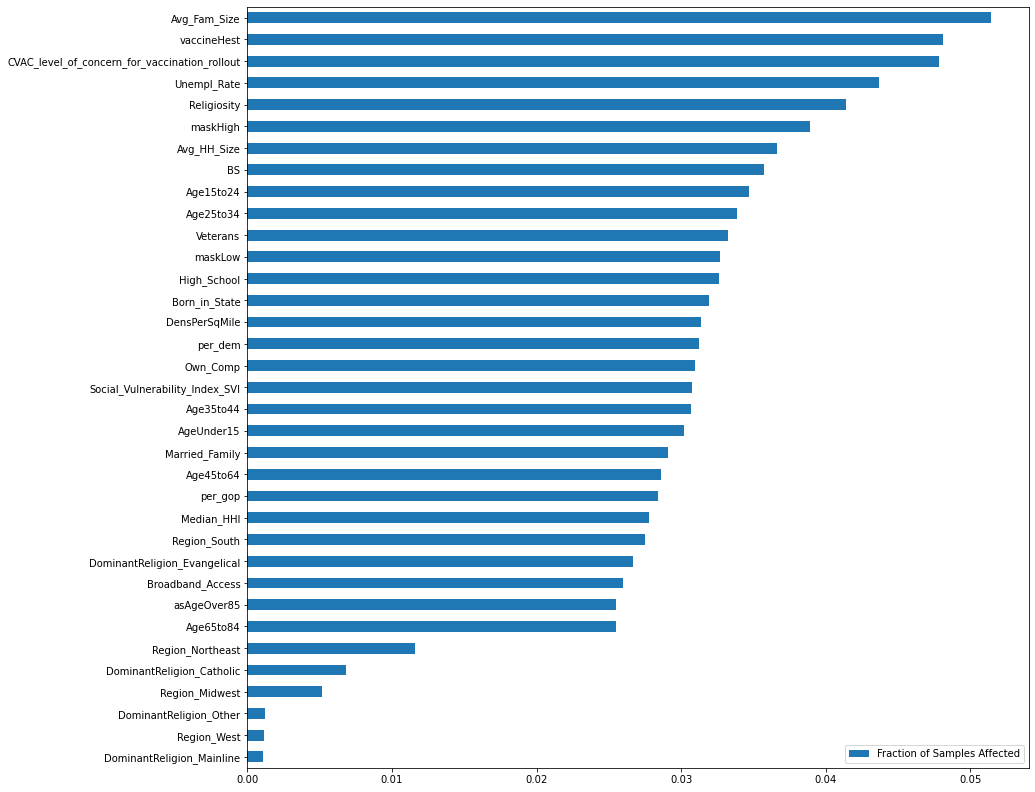

In [114]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize = (14,14));

<AxesSubplot:>

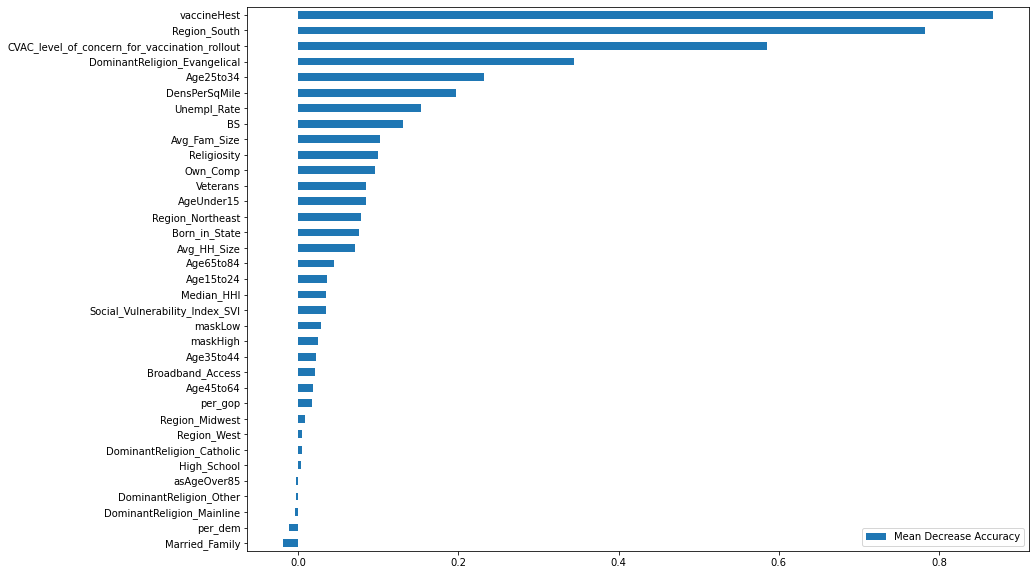

In [117]:
# manual shuffle 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

rf = RandomForestRegressor()
scores = defaultdict(list)


names = X.columns
 
rf = RandomForestRegressor()
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(100, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10))

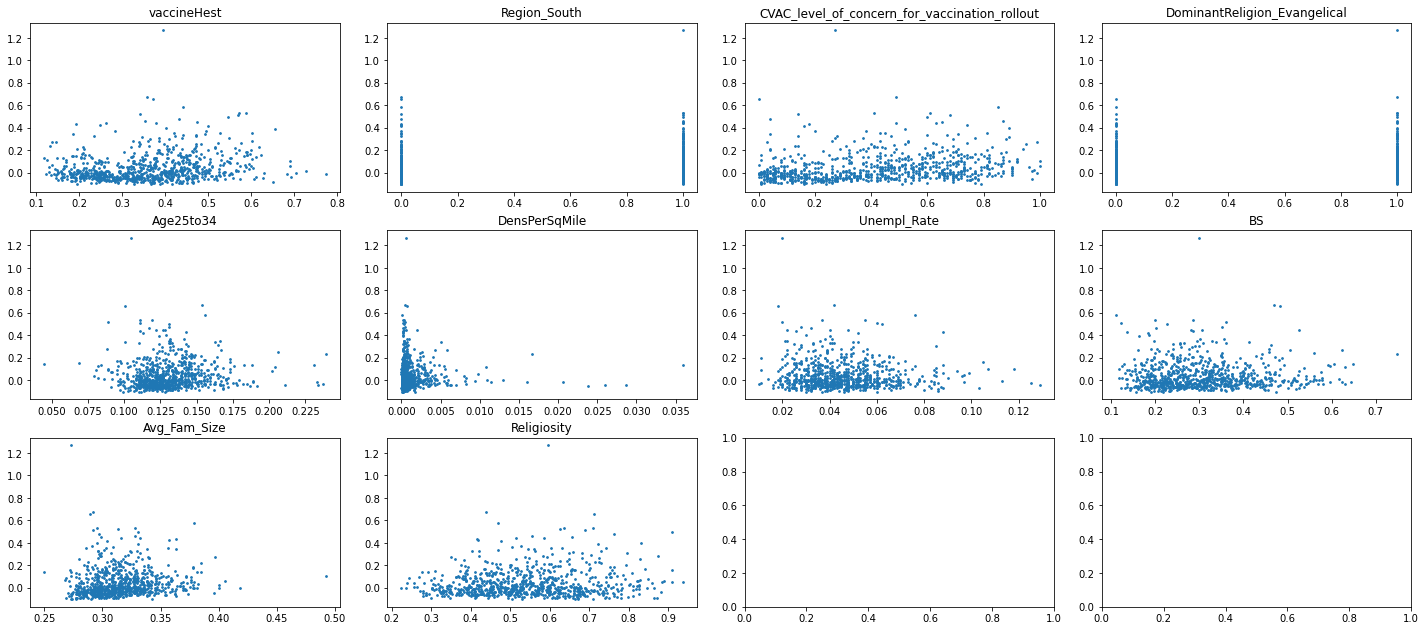

In [162]:
cols = ['vaccineHest','Region_South','CVAC_level_of_concern_for_vaccination_rollout','DominantReligion_Evangelical','Age25to34','DensPerSqMile','Unempl_Rate','BS','Avg_Fam_Size','Religiosity']

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

for ax, col in zip(axs.flatten(),cols):
    #print(col)
    ax.scatter(covid[col], y, s=3)
    ax.set_title(col)

plt.tight_layout()
plt.subplots_adjust(top=0.85)     # Add space at top
plt.savefig('feature_imp2.png', bbox_inches="tight")
plt.show()   


vaccineHest
Region_South
CVAC_level_of_concern_for_vaccination_rollout
DominantReligion_Evangelical
Age25to34
DensPerSqMile
Unempl_Rate
BS
Avg_Fam_Size
Religiosity


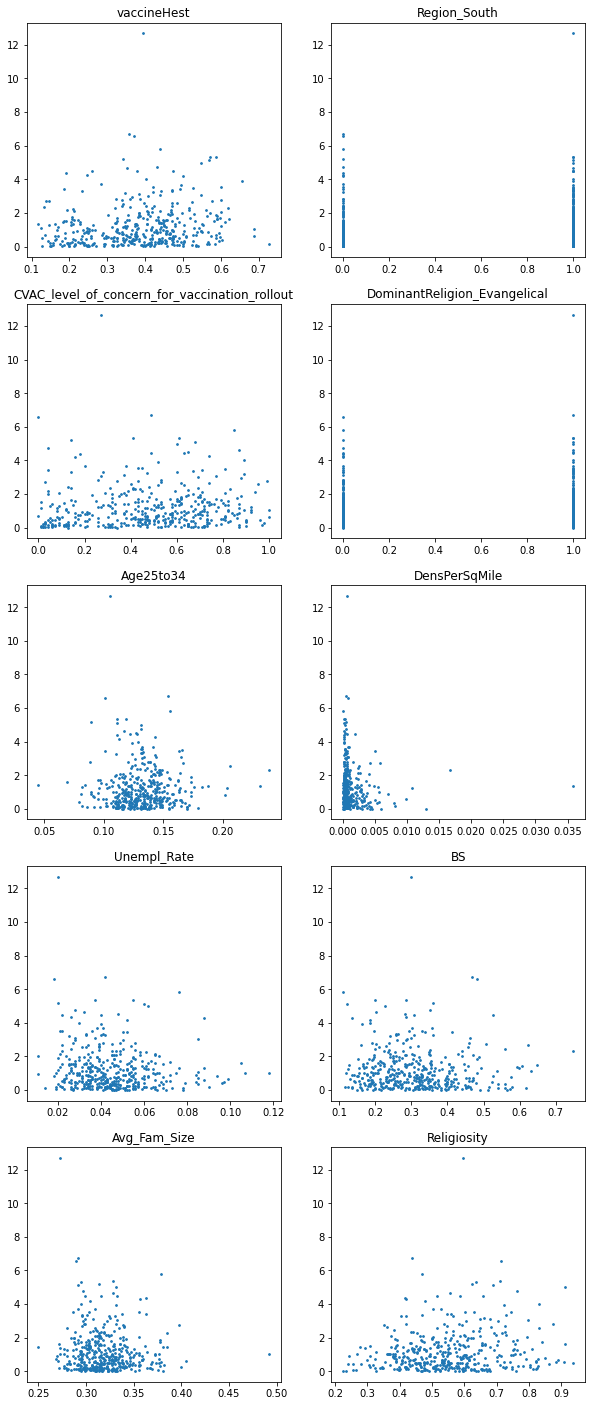

In [149]:
#count counties with increasing numbers
#count counties with decreasing numbers
#plot correlations
increasing = covid[covid.Target_PctChg > 0]
y_inc = increasing.pop('Target_PctChg')

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,25))

for ax, col in zip(axs.flatten(),cols):
    print(col)
    ax.scatter(increasing[col], y_inc, s=3)
    ax.set_title(col)
    

plt.show()   

In [146]:
from numpy import mean, std
from scipy.stats import pearsonr, spearmanr

def compute_correlation(a, b):
    '''take in numpy arrays and computer correlation between them'''
    return pearsonr(a, b)


In [145]:
for col in cols:
    print('{} {}'.format(col,compute_correlation(covid[col],y)))
    

Pearsons correlation: vaccineHest (0.21151337057572087, 1.42187755405234e-09)
Pearsons correlation: Region_South (0.29467027271683416, 1.4995477084624934e-17)
Pearsons correlation: CVAC_level_of_concern_for_vaccination_rollout (0.23368293585049113, 2.0187495771271906e-11)
Pearsons correlation: DominantReligion_Evangelical (0.27892463958162517, 8.146437394345154e-16)
Pearsons correlation: Age25to34 (0.04442660226562778, 0.2085408806483527)
Pearsons correlation: DensPerSqMile (-0.02392870826969257, 0.4983332699902784)
Pearsons correlation: Unempl_Rate (-0.06116122787021249, 0.0832623180663815)
Pearsons correlation: BS (0.005154074623144884, 0.8840589268336317)
Pearsons correlation: Avg_Fam_Size (0.09727112497281143, 0.00580412092703997)
Pearsons correlation: Religiosity (0.10896003008733031, 0.0019879370825567227)


In [147]:
for col in cols:
    print('{} {}'.format(col,spearmanr(covid[col],y)))

vaccineHest SpearmanrResult(correlation=0.23101422177555594, pvalue=3.4504568621845896e-11)
Region_South SpearmanrResult(correlation=0.3863175210463918, pvalue=5.591021946649637e-30)
CVAC_level_of_concern_for_vaccination_rollout SpearmanrResult(correlation=0.31900966079046755, pvalue=1.8784533273543856e-20)
DominantReligion_Evangelical SpearmanrResult(correlation=0.31060229693415836, pvalue=2.0282940917068163e-19)
Age25to34 SpearmanrResult(correlation=0.13649018025615306, pvalue=0.0001044980510217231)
DensPerSqMile SpearmanrResult(correlation=0.02459671188036984, pvalue=0.48641454282048446)
Unempl_Rate SpearmanrResult(correlation=-0.027850355889976294, pvalue=0.43062294994257366)
BS SpearmanrResult(correlation=0.035396571563510705, pvalue=0.3164435386594198)
Avg_Fam_Size SpearmanrResult(correlation=0.2157029084571935, pvalue=6.585017897605793e-10)
Religiosity SpearmanrResult(correlation=0.06407844032082628, pvalue=0.0695479106363504)


In [ ]:
# Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If you're working in Jupyter Notebook, include the following so that plots will display:
%matplotlib inline

In [207]:
#plot the errors of the different models
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y_test.index, y_hat_mean - y_test, c='r')
ax.plot(y_test.index, y_hat_ols - y_test, c='b')
ax.plot(y_test.index, y_hat_dt - y_test, c='g')
ax.plot(y_test.index, rf_predictions - y_test, c='purple')

ValueError: operands could not be broadcast together with shapes (241,) (161,) 